## Description

### Model

A single LSTM layer was used for this notebook. Here, the model performed best with a dropout of 0.4 and a learning rate of 1e-4. To handle varied sentence lengths pack_padded_sequence was used from the PyTorch library. Early stopping was employed during training.

### Results

The highest accuracy achieved is roughly 63%. Based on the training and validation plots, the model is overfitting on the dataset, which could be due to insufficient data.

### Resources Used:

*   [Multiclass Text Classification using LSTM in Pytorch](https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df)
*   [Build Your First Text Classification model using PyTorch](https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/)
* [TORCH.NN.UTILS.RNN.PACK_PADDED_SEQUENCE](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html)



## Imports

In [1]:
# !pip install torchtext==0.6.0

In [2]:
import math
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, TabularDataset
from torchtext.vocab import Vectors
import torch.nn.functional as F
from torch import nn, optim
from torch.nn.utils.rnn import pack_padded_sequence

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definitions

In [3]:
batch_size = 16

PATH = "/content/drive/MyDrive/Class Stuff/Fall23/NLP/Final Project/Data"
train_path = os.path.join(PATH,"train.csv")
val_path = os.path.join(PATH,"val.csv")
test_path = os.path.join(PATH,"test.csv")

## Data Loaders

In [4]:
TEXT = Field(sequential=True, lower=True, include_lengths=False, batch_first=True)
LABEL = Field(sequential=False, use_vocab=False)

fields = [('sentence', TEXT), ('label', LABEL)]

In [5]:
train_data = TabularDataset(
    path=train_path,
    format="csv",
    fields=fields,
    skip_header=True
)

val_data = TabularDataset(
    path=val_path,
    format="csv",
    fields=fields,
    skip_header=True
)

test_data = TabularDataset(
    path=test_path,
    format="csv",
    fields=fields,
    skip_header=True
)

In [6]:
glove_vectors = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=50_000)

In [7]:
TEXT.build_vocab(train_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(train_data)

TEXT.build_vocab(val_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(val_data)

TEXT.build_vocab(test_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(test_data)

In [8]:
train_iter = torchtext.data.BucketIterator(
    dataset=train_data,
    batch_size=batch_size
)

val_iter = torchtext.data.BucketIterator(
    dataset=val_data,
    batch_size=batch_size
)

test_iter = torchtext.data.BucketIterator(
    dataset=test_data,
    batch_size=batch_size
)

In [9]:
N_train = 0
N_val = 0
N_test = 0
for x,y in train_iter:
  N_train+=len(x[0])
for x,y in val_iter:
    N_val+=len(x[0])
for x,y in test_iter:
    N_test+=len(x[0])

## Model Definition

In [10]:
class LSTM_model(torch.nn.Module):
    def __init__(self, embeddings, hidden_dim,dropout = 0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embeddings.size(1), hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        s = torch.sum(x != 0, dim=1)
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [11]:
model = LSTM_model(TEXT.vocab.vectors,hidden_dim = 20,dropout=0.4)

In [12]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the transformer model: {params}")

Number of parameters in the transformer model: 47152


## Plot Definitions

In [13]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy,last_epoch):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss[:last_epoch],label='Training',color='g')
    plt.plot(validation_loss[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[last_epoch],6))
    print('Final Validation Loss:',np.around(validation_loss[last_epoch],6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy[:last_epoch],label='Training',color='g')
    plt.plot(validation_accuracy[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[last_epoch],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[last_epoch],6))
    print()

    print("Test Accuracy:", np.around(test_accuracy.item(),4))

    print()

## Training

In [14]:
epochs = 400
lr = 1e-4

best_val_score = float("-inf")
count_no_improvements = 0
earlyStop = 25
last_epoch = 0

WEIGHTS_PATH = "/content/drive/MyDrive/Class Stuff/Fall23/NLP/Final Project/Weights/lstm.pt"

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

torch.manual_seed(10)

training_losses = np.zeros(epochs)
val_losses      = np.zeros(epochs)

training_accuracy = np.zeros(epochs)
val_accuracy      = np.zeros(epochs)

for epoch in tqdm(range(epochs)):
    print(f"{epoch=}")
    epoch_loss = 0
    epoch_correct = 0
    epoch_count = 0
    for idx, batch in enumerate(iter(train_iter)):
        predictions = model(batch.sentence.to(device))
        labels = F.one_hot(batch.label, num_classes=2).float().to(device)

        loss = criterion(predictions, labels)

        correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

        epoch_correct += correct.sum().item()

        epoch_loss += loss.item()

        training_losses[epoch]   = epoch_loss/N_train
        training_accuracy[epoch] = epoch_correct/N_train

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()

    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_correct = 0

        for idx, batch in enumerate(iter(val_iter)):
            predictions = model(batch.sentence.to(device))
            labels = F.one_hot(batch.label, num_classes=2).float().to(device)
            test_loss = criterion(predictions, labels)

            correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

            val_epoch_correct += correct.sum().item()
            val_epoch_loss += loss.item()

            val_losses[epoch]   = val_epoch_loss/N_val
            val_accuracy[epoch] = val_epoch_correct/N_val
        if val_accuracy[epoch]>best_val_score:
          best_val_score = val_accuracy[epoch]
          torch.save(model.state_dict(), WEIGHTS_PATH)
          count_no_improvements = 0
        else:
          count_no_improvements+=1
          if count_no_improvements>earlyStop:
            last_epoch = epoch
            break
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {training_losses[epoch]}, Train Accuracy: {training_accuracy[epoch]}")
    print(f"Validation Loss: {val_losses[epoch]}, Validation Accuracy: {val_accuracy[epoch]}")
    last_epoch = epoch

  0%|          | 0/400 [00:00<?, ?it/s]

epoch=0


  0%|          | 1/400 [00:02<15:21,  2.31s/it]

Epoch: 0
Train Loss: 0.04245266699790955, Train Accuracy: 0.6186666666666667
Validation Loss: 0.045027971267700195, Validation Accuracy: 0.6236559139784946
epoch=1


  0%|          | 2/400 [00:03<11:03,  1.67s/it]

Epoch: 1
Train Loss: 0.04230398042996725, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04097079077074604, Validation Accuracy: 0.6236559139784946
epoch=2


  1%|          | 3/400 [00:05<10:31,  1.59s/it]

Epoch: 2
Train Loss: 0.04221317481994629, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04347147864680136, Validation Accuracy: 0.6236559139784946
epoch=3


  1%|          | 4/400 [00:06<09:45,  1.48s/it]

Epoch: 3
Train Loss: 0.042086410919825235, Train Accuracy: 0.6186666666666667
Validation Loss: 0.044192487193692113, Validation Accuracy: 0.6236559139784946
epoch=4


  1%|▏         | 5/400 [00:07<09:27,  1.44s/it]

Epoch: 4
Train Loss: 0.04189121929804484, Train Accuracy: 0.6186666666666667
Validation Loss: 0.045954331274955504, Validation Accuracy: 0.6236559139784946
epoch=5


  2%|▏         | 6/400 [00:09<09:39,  1.47s/it]

Epoch: 5
Train Loss: 0.041810614347457885, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04282355308532715, Validation Accuracy: 0.6236559139784946
epoch=6


  2%|▏         | 7/400 [00:10<09:19,  1.42s/it]

Epoch: 6
Train Loss: 0.041682061831156414, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04126693356421686, Validation Accuracy: 0.6236559139784946
epoch=7


  2%|▏         | 8/400 [00:11<09:19,  1.43s/it]

Epoch: 7
Train Loss: 0.04157738828659058, Train Accuracy: 0.6186666666666667
Validation Loss: 0.05014863321858068, Validation Accuracy: 0.6236559139784946
epoch=8


  2%|▏         | 9/400 [00:13<08:43,  1.34s/it]

Epoch: 8
Train Loss: 0.04148513499895732, Train Accuracy: 0.6186666666666667
Validation Loss: 0.03895194684305499, Validation Accuracy: 0.6236559139784946
epoch=9


  2%|▎         | 10/400 [00:14<07:48,  1.20s/it]

Epoch: 9
Train Loss: 0.04140044585863749, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04648647000712733, Validation Accuracy: 0.6236559139784946
epoch=10


  3%|▎         | 11/400 [00:15<07:20,  1.13s/it]

Epoch: 10
Train Loss: 0.04128708338737488, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04199737887228689, Validation Accuracy: 0.6236559139784946
epoch=11


  3%|▎         | 12/400 [00:15<06:56,  1.07s/it]

Epoch: 11
Train Loss: 0.041151510874430336, Train Accuracy: 0.62
Validation Loss: 0.03260201792563162, Validation Accuracy: 0.6236559139784946
epoch=12


  3%|▎         | 13/400 [00:16<06:32,  1.01s/it]

Epoch: 12
Train Loss: 0.04086526397864024, Train Accuracy: 0.6186666666666667
Validation Loss: 0.045411794416366086, Validation Accuracy: 0.6236559139784946
epoch=13


  4%|▎         | 14/400 [00:17<06:15,  1.03it/s]

Epoch: 13
Train Loss: 0.0403106636206309, Train Accuracy: 0.6186666666666667
Validation Loss: 0.03611400435047765, Validation Accuracy: 0.6236559139784946
epoch=14


  4%|▍         | 15/400 [00:18<06:05,  1.05it/s]

Epoch: 14
Train Loss: 0.04015656526883443, Train Accuracy: 0.6186666666666667
Validation Loss: 0.038462204317892754, Validation Accuracy: 0.6236559139784946
epoch=15


  4%|▍         | 16/400 [00:19<05:32,  1.15it/s]

Epoch: 15
Train Loss: 0.03921281802654266, Train Accuracy: 0.6186666666666667
Validation Loss: 0.02839196305121145, Validation Accuracy: 0.6344086021505376
epoch=16


  4%|▍         | 17/400 [00:19<05:03,  1.26it/s]

Epoch: 16
Train Loss: 0.03910795299212138, Train Accuracy: 0.6226666666666667
Validation Loss: 0.046357720128951535, Validation Accuracy: 0.6236559139784946
epoch=17


  4%|▍         | 18/400 [00:20<04:39,  1.37it/s]

Epoch: 17
Train Loss: 0.03811061918735504, Train Accuracy: 0.6253333333333333
Validation Loss: 0.0297567690572431, Validation Accuracy: 0.6344086021505376
epoch=18


  5%|▍         | 19/400 [00:21<04:25,  1.43it/s]

Epoch: 18
Train Loss: 0.03800966684023539, Train Accuracy: 0.624
Validation Loss: 0.04025820762880387, Validation Accuracy: 0.6236559139784946
epoch=19


  5%|▌         | 20/400 [00:21<04:16,  1.48it/s]

Epoch: 19
Train Loss: 0.03798361436525981, Train Accuracy: 0.6253333333333333
Validation Loss: 0.031483819407801476, Validation Accuracy: 0.6236559139784946
epoch=20


  5%|▌         | 21/400 [00:22<04:06,  1.54it/s]

Epoch: 20
Train Loss: 0.03799377290407817, Train Accuracy: 0.6253333333333333
Validation Loss: 0.03885263781393728, Validation Accuracy: 0.6236559139784946
epoch=21


  6%|▌         | 22/400 [00:22<04:02,  1.56it/s]

Epoch: 21
Train Loss: 0.037791996876398726, Train Accuracy: 0.628
Validation Loss: 0.04316405327089371, Validation Accuracy: 0.6451612903225806
epoch=22


  6%|▌         | 23/400 [00:23<03:56,  1.59it/s]

Epoch: 22
Train Loss: 0.036689270655314125, Train Accuracy: 0.64
Validation Loss: 0.03250218206836331, Validation Accuracy: 0.6236559139784946
epoch=23


  6%|▌         | 24/400 [00:24<03:53,  1.61it/s]

Epoch: 23
Train Loss: 0.036679935296376545, Train Accuracy: 0.644
Validation Loss: 0.043269626555904266, Validation Accuracy: 0.6559139784946236
epoch=24


  6%|▋         | 25/400 [00:24<03:50,  1.63it/s]

Epoch: 24
Train Loss: 0.03734719165166219, Train Accuracy: 0.636
Validation Loss: 0.041622584865939234, Validation Accuracy: 0.6236559139784946
epoch=25


  6%|▋         | 26/400 [00:25<03:49,  1.63it/s]

Epoch: 25
Train Loss: 0.037056749065717064, Train Accuracy: 0.6386666666666667
Validation Loss: 0.03793418791986281, Validation Accuracy: 0.6236559139784946
epoch=26


  7%|▋         | 27/400 [00:25<03:48,  1.63it/s]

Epoch: 26
Train Loss: 0.0365458120505015, Train Accuracy: 0.6506666666666666
Validation Loss: 0.030833651942591512, Validation Accuracy: 0.6451612903225806
epoch=27


  7%|▋         | 28/400 [00:26<03:46,  1.64it/s]

Epoch: 27
Train Loss: 0.03662292222181956, Train Accuracy: 0.66
Validation Loss: 0.030228560970675562, Validation Accuracy: 0.6559139784946236
epoch=28


  7%|▋         | 29/400 [00:27<03:46,  1.64it/s]

Epoch: 28
Train Loss: 0.035837379614512124, Train Accuracy: 0.6786666666666666
Validation Loss: 0.0302779040028972, Validation Accuracy: 0.6344086021505376
epoch=29


  8%|▊         | 30/400 [00:27<03:44,  1.65it/s]

Epoch: 29
Train Loss: 0.03608638095855713, Train Accuracy: 0.692
Validation Loss: 0.03158660473362092, Validation Accuracy: 0.6236559139784946
epoch=30


  8%|▊         | 31/400 [00:28<03:43,  1.65it/s]

Epoch: 30
Train Loss: 0.035689709464708966, Train Accuracy: 0.6946666666666667
Validation Loss: 0.03093412422364758, Validation Accuracy: 0.6236559139784946
epoch=31


  8%|▊         | 32/400 [00:29<03:54,  1.57it/s]

Epoch: 31
Train Loss: 0.03580181058247884, Train Accuracy: 0.7133333333333334
Validation Loss: 0.03147934329125189, Validation Accuracy: 0.6236559139784946
epoch=32


  8%|▊         | 33/400 [00:29<04:23,  1.39it/s]

Epoch: 32
Train Loss: 0.03578149747848511, Train Accuracy: 0.7053333333333334
Validation Loss: 0.024898169502135244, Validation Accuracy: 0.6021505376344086
epoch=33


  8%|▊         | 34/400 [00:30<04:44,  1.28it/s]

Epoch: 33
Train Loss: 0.03490979675451914, Train Accuracy: 0.708
Validation Loss: 0.04164592296846451, Validation Accuracy: 0.5591397849462365
epoch=34


  9%|▉         | 35/400 [00:31<04:59,  1.22it/s]

Epoch: 34
Train Loss: 0.035779083530108134, Train Accuracy: 0.72
Validation Loss: 0.03704381373620803, Validation Accuracy: 0.5591397849462365
epoch=35


  9%|▉         | 36/400 [00:32<05:09,  1.18it/s]

Epoch: 35
Train Loss: 0.03555977435906728, Train Accuracy: 0.7186666666666667
Validation Loss: 0.02734878178565733, Validation Accuracy: 0.6666666666666666
epoch=36


  9%|▉         | 37/400 [00:33<05:17,  1.14it/s]

Epoch: 36
Train Loss: 0.03600407151381175, Train Accuracy: 0.7213333333333334
Validation Loss: 0.020406126976013184, Validation Accuracy: 0.5806451612903226
epoch=37


 10%|▉         | 38/400 [00:34<05:21,  1.13it/s]

Epoch: 37
Train Loss: 0.034759836316108704, Train Accuracy: 0.7186666666666667
Validation Loss: 0.0338541038574711, Validation Accuracy: 0.5591397849462365
epoch=38


 10%|▉         | 39/400 [00:35<04:49,  1.25it/s]

Epoch: 38
Train Loss: 0.035353634397188825, Train Accuracy: 0.7133333333333334
Validation Loss: 0.03068543634107036, Validation Accuracy: 0.6236559139784946
epoch=39


 10%|█         | 40/400 [00:35<04:27,  1.35it/s]

Epoch: 39
Train Loss: 0.03444567074378332, Train Accuracy: 0.7373333333333333
Validation Loss: 0.025397681420849215, Validation Accuracy: 0.6451612903225806
epoch=40


 10%|█         | 41/400 [00:36<04:10,  1.43it/s]

Epoch: 40
Train Loss: 0.03554387454191844, Train Accuracy: 0.7146666666666667
Validation Loss: 0.04498127583534487, Validation Accuracy: 0.6129032258064516
epoch=41


 10%|█         | 42/400 [00:36<03:57,  1.50it/s]

Epoch: 41
Train Loss: 0.035430956363677976, Train Accuracy: 0.7146666666666667
Validation Loss: 0.03236378392865581, Validation Accuracy: 0.5913978494623656
epoch=42


 11%|█         | 43/400 [00:37<03:52,  1.53it/s]

Epoch: 42
Train Loss: 0.03619919006029765, Train Accuracy: 0.6946666666666667
Validation Loss: 0.03262769406841647, Validation Accuracy: 0.5806451612903226
epoch=43


 11%|█         | 44/400 [00:38<03:50,  1.55it/s]

Epoch: 43
Train Loss: 0.03463499836126963, Train Accuracy: 0.7226666666666667
Validation Loss: 0.035108489374960625, Validation Accuracy: 0.5698924731182796
epoch=44


 11%|█▏        | 45/400 [00:38<03:47,  1.56it/s]

Epoch: 44
Train Loss: 0.03423062388102214, Train Accuracy: 0.7373333333333333
Validation Loss: 0.038232034252535914, Validation Accuracy: 0.6236559139784946
epoch=45


 12%|█▏        | 46/400 [00:39<03:43,  1.58it/s]

Epoch: 45
Train Loss: 0.03483651868502299, Train Accuracy: 0.7173333333333334
Validation Loss: 0.037255087206440586, Validation Accuracy: 0.6129032258064516
epoch=46


 12%|█▏        | 47/400 [00:40<03:41,  1.60it/s]

Epoch: 46
Train Loss: 0.035298728903134666, Train Accuracy: 0.7226666666666667
Validation Loss: 0.040858941693459785, Validation Accuracy: 0.6236559139784946
epoch=47


 12%|█▏        | 48/400 [00:40<03:39,  1.60it/s]

Epoch: 47
Train Loss: 0.03470436910788218, Train Accuracy: 0.732
Validation Loss: 0.025413659311109973, Validation Accuracy: 0.6666666666666666
epoch=48


 12%|█▏        | 49/400 [00:41<03:34,  1.63it/s]

Epoch: 48
Train Loss: 0.03431239879131317, Train Accuracy: 0.7386666666666667
Validation Loss: 0.030470640428604617, Validation Accuracy: 0.6451612903225806
epoch=49


 12%|█▎        | 50/400 [00:41<03:35,  1.63it/s]

Epoch: 49
Train Loss: 0.034758145531018574, Train Accuracy: 0.7346666666666667
Validation Loss: 0.057166960931593375, Validation Accuracy: 0.6021505376344086
epoch=50


 13%|█▎        | 51/400 [00:42<03:32,  1.64it/s]

Epoch: 50
Train Loss: 0.03475815085570017, Train Accuracy: 0.7333333333333333
Validation Loss: 0.04002092346068351, Validation Accuracy: 0.5913978494623656
epoch=51


 13%|█▎        | 52/400 [00:43<03:31,  1.65it/s]

Epoch: 51
Train Loss: 0.03449919311205546, Train Accuracy: 0.72
Validation Loss: 0.029264142436365926, Validation Accuracy: 0.6236559139784946
epoch=52


 13%|█▎        | 53/400 [00:43<03:32,  1.64it/s]

Epoch: 52
Train Loss: 0.03441868100563685, Train Accuracy: 0.7333333333333333
Validation Loss: 0.027725615809040684, Validation Accuracy: 0.6344086021505376
epoch=53


 14%|█▎        | 54/400 [00:44<03:29,  1.65it/s]

Epoch: 53
Train Loss: 0.03442178901036581, Train Accuracy: 0.732
Validation Loss: 0.028342410441367857, Validation Accuracy: 0.5806451612903226
epoch=54


 14%|█▍        | 55/400 [00:45<03:57,  1.45it/s]

Epoch: 54
Train Loss: 0.03496084574858348, Train Accuracy: 0.7253333333333334
Validation Loss: 0.03674351015398579, Validation Accuracy: 0.6774193548387096
epoch=55


 14%|█▍        | 56/400 [00:46<04:20,  1.32it/s]

Epoch: 55
Train Loss: 0.033263135075569154, Train Accuracy: 0.7493333333333333
Validation Loss: 0.040327299025750926, Validation Accuracy: 0.6344086021505376
epoch=56


 14%|█▍        | 57/400 [00:47<04:39,  1.23it/s]

Epoch: 56
Train Loss: 0.034327580014864606, Train Accuracy: 0.7293333333333333
Validation Loss: 0.04031782380996212, Validation Accuracy: 0.6129032258064516
epoch=57


 14%|█▍        | 58/400 [00:48<04:50,  1.18it/s]

Epoch: 57
Train Loss: 0.03393765862782796, Train Accuracy: 0.7333333333333333
Validation Loss: 0.04507072510257844, Validation Accuracy: 0.6129032258064516
epoch=58


 15%|█▍        | 59/400 [00:48<04:55,  1.15it/s]

Epoch: 58
Train Loss: 0.034764731725056966, Train Accuracy: 0.7426666666666667
Validation Loss: 0.034034032975473714, Validation Accuracy: 0.5806451612903226
epoch=59


 15%|█▌        | 60/400 [00:49<04:59,  1.14it/s]

Epoch: 59
Train Loss: 0.03417825388908386, Train Accuracy: 0.74
Validation Loss: 0.0464934725915232, Validation Accuracy: 0.6129032258064516
epoch=60


 15%|█▌        | 61/400 [00:50<04:51,  1.16it/s]

Epoch: 60
Train Loss: 0.035078946113586425, Train Accuracy: 0.736
Validation Loss: 0.05429126754883797, Validation Accuracy: 0.6881720430107527
epoch=61


 16%|█▌        | 62/400 [00:51<04:27,  1.26it/s]

Epoch: 61
Train Loss: 0.034202275395393375, Train Accuracy: 0.744
Validation Loss: 0.030749040265237133, Validation Accuracy: 0.5806451612903226
epoch=62


 16%|█▌        | 63/400 [00:51<04:08,  1.36it/s]

Epoch: 62
Train Loss: 0.03439276484648387, Train Accuracy: 0.736
Validation Loss: 0.031726068066012476, Validation Accuracy: 0.6129032258064516
epoch=63


 16%|█▌        | 64/400 [00:52<03:54,  1.44it/s]

Epoch: 63
Train Loss: 0.03412914760907491, Train Accuracy: 0.74
Validation Loss: 0.027160321512529926, Validation Accuracy: 0.6559139784946236
epoch=64


 16%|█▋        | 65/400 [00:53<03:48,  1.47it/s]

Epoch: 64
Train Loss: 0.0328850888411204, Train Accuracy: 0.7546666666666667
Validation Loss: 0.023698887517375332, Validation Accuracy: 0.6129032258064516
epoch=65


 16%|█▋        | 66/400 [00:53<03:39,  1.52it/s]

Epoch: 65
Train Loss: 0.0335223780075709, Train Accuracy: 0.7453333333333333
Validation Loss: 0.019720662024713332, Validation Accuracy: 0.6559139784946236
epoch=66


 17%|█▋        | 67/400 [00:54<03:35,  1.55it/s]

Epoch: 66
Train Loss: 0.03302885242303213, Train Accuracy: 0.76
Validation Loss: 0.0273802972608997, Validation Accuracy: 0.5591397849462365
epoch=67


 17%|█▋        | 68/400 [00:54<03:28,  1.59it/s]

Epoch: 67
Train Loss: 0.034381620168685914, Train Accuracy: 0.7426666666666667
Validation Loss: 0.03432100049911007, Validation Accuracy: 0.6666666666666666
epoch=68


 17%|█▋        | 69/400 [00:55<03:26,  1.60it/s]

Epoch: 68
Train Loss: 0.03352730576197306, Train Accuracy: 0.7533333333333333
Validation Loss: 0.0476536750793457, Validation Accuracy: 0.6129032258064516
epoch=69


 18%|█▊        | 70/400 [00:56<03:26,  1.60it/s]

Epoch: 69
Train Loss: 0.03295483255386353, Train Accuracy: 0.7506666666666667
Validation Loss: 0.030557017172536543, Validation Accuracy: 0.6774193548387096
epoch=70


 18%|█▊        | 71/400 [00:56<03:24,  1.61it/s]

Epoch: 70
Train Loss: 0.0329785330692927, Train Accuracy: 0.7506666666666667
Validation Loss: 0.029847898790913242, Validation Accuracy: 0.6344086021505376
epoch=71


 18%|█▊        | 72/400 [00:57<03:25,  1.60it/s]

Epoch: 71
Train Loss: 0.033030555566151934, Train Accuracy: 0.7533333333333333
Validation Loss: 0.028460283433237383, Validation Accuracy: 0.6344086021505376
epoch=72


 18%|█▊        | 73/400 [00:58<03:22,  1.61it/s]

Epoch: 72
Train Loss: 0.03283707173665364, Train Accuracy: 0.7586666666666667
Validation Loss: 0.02759432215844431, Validation Accuracy: 0.6344086021505376
epoch=73


 18%|█▊        | 74/400 [00:58<03:22,  1.61it/s]

Epoch: 73
Train Loss: 0.03271246194839478, Train Accuracy: 0.756
Validation Loss: 0.030798067969660604, Validation Accuracy: 0.6236559139784946
epoch=74


 19%|█▉        | 75/400 [00:59<03:21,  1.61it/s]

Epoch: 74
Train Loss: 0.03248155494530996, Train Accuracy: 0.7586666666666667
Validation Loss: 0.03253271887379308, Validation Accuracy: 0.6666666666666666
epoch=75


 19%|█▉        | 76/400 [00:59<03:19,  1.63it/s]

Epoch: 75
Train Loss: 0.03128543901443481, Train Accuracy: 0.776
Validation Loss: 0.023613977816797072, Validation Accuracy: 0.6881720430107527
epoch=76


 19%|█▉        | 77/400 [01:00<03:23,  1.59it/s]

Epoch: 76
Train Loss: 0.03138620102405548, Train Accuracy: 0.7826666666666666
Validation Loss: 0.038187611487603954, Validation Accuracy: 0.6559139784946236
epoch=77


 20%|█▉        | 78/400 [01:01<03:52,  1.39it/s]

Epoch: 77
Train Loss: 0.03301482864220937, Train Accuracy: 0.7453333333333333
Validation Loss: 0.034477549214516914, Validation Accuracy: 0.6236559139784946
epoch=78


 20%|█▉        | 79/400 [01:02<04:10,  1.28it/s]

Epoch: 78
Train Loss: 0.03194377283255259, Train Accuracy: 0.776
Validation Loss: 0.02243122939140566, Validation Accuracy: 0.6344086021505376
epoch=79


 20%|██        | 80/400 [01:03<04:28,  1.19it/s]

Epoch: 79
Train Loss: 0.0319980278412501, Train Accuracy: 0.7586666666666667
Validation Loss: 0.03395647771896854, Validation Accuracy: 0.6989247311827957
epoch=80


 20%|██        | 81/400 [01:04<04:33,  1.17it/s]

Epoch: 80
Train Loss: 0.03166585067907969, Train Accuracy: 0.7813333333333333
Validation Loss: 0.03910127378279163, Validation Accuracy: 0.6021505376344086
epoch=81


 20%|██        | 82/400 [01:05<04:37,  1.15it/s]

Epoch: 81
Train Loss: 0.03206588900089264, Train Accuracy: 0.7693333333333333
Validation Loss: 0.04510719929972003, Validation Accuracy: 0.6666666666666666
epoch=82


 21%|██        | 83/400 [01:06<04:46,  1.11it/s]

Epoch: 82
Train Loss: 0.03186434038480123, Train Accuracy: 0.7706666666666667
Validation Loss: 0.038973392978791266, Validation Accuracy: 0.5913978494623656
epoch=83


 21%|██        | 84/400 [01:06<04:21,  1.21it/s]

Epoch: 83
Train Loss: 0.03173835897445679, Train Accuracy: 0.772
Validation Loss: 0.03351943723617062, Validation Accuracy: 0.5698924731182796
epoch=84


 21%|██▏       | 85/400 [01:07<04:00,  1.31it/s]

Epoch: 84
Train Loss: 0.0326041476726532, Train Accuracy: 0.7613333333333333
Validation Loss: 0.03478125987514373, Validation Accuracy: 0.6774193548387096
epoch=85


 22%|██▏       | 86/400 [01:08<03:46,  1.39it/s]

Epoch: 85
Train Loss: 0.03260287006696065, Train Accuracy: 0.7546666666666667
Validation Loss: 0.03462304222968317, Validation Accuracy: 0.6774193548387096
epoch=86


 22%|██▏       | 87/400 [01:08<03:35,  1.45it/s]

Epoch: 86
Train Loss: 0.032675994594891865, Train Accuracy: 0.7466666666666667
Validation Loss: 0.03895674213286369, Validation Accuracy: 0.6774193548387096
epoch=87


 22%|██▏       | 88/400 [01:09<03:27,  1.50it/s]

Epoch: 87
Train Loss: 0.03130716065565745, Train Accuracy: 0.7666666666666667
Validation Loss: 0.034920430952502836, Validation Accuracy: 0.6559139784946236
epoch=88


 22%|██▏       | 89/400 [01:09<03:23,  1.53it/s]

Epoch: 88
Train Loss: 0.031117900331815083, Train Accuracy: 0.7773333333333333
Validation Loss: 0.04323271397621401, Validation Accuracy: 0.5806451612903226
epoch=89


 22%|██▎       | 90/400 [01:10<03:19,  1.55it/s]

Epoch: 89
Train Loss: 0.03134385844071706, Train Accuracy: 0.772
Validation Loss: 0.035203710679085023, Validation Accuracy: 0.6559139784946236
epoch=90


 23%|██▎       | 91/400 [01:11<03:18,  1.56it/s]

Epoch: 90
Train Loss: 0.03140544458230336, Train Accuracy: 0.768
Validation Loss: 0.03069476350661247, Validation Accuracy: 0.6666666666666666
epoch=91


 23%|██▎       | 92/400 [01:11<03:17,  1.56it/s]

Epoch: 91
Train Loss: 0.03204399659236272, Train Accuracy: 0.7533333333333333
Validation Loss: 0.02525522631983603, Validation Accuracy: 0.6451612903225806
epoch=92


 23%|██▎       | 93/400 [01:12<03:14,  1.58it/s]

Epoch: 92
Train Loss: 0.03136618415514628, Train Accuracy: 0.7786666666666666
Validation Loss: 0.030303216749621976, Validation Accuracy: 0.6236559139784946
epoch=93


 24%|██▎       | 94/400 [01:13<03:13,  1.59it/s]

Epoch: 93
Train Loss: 0.031156183163324993, Train Accuracy: 0.7706666666666667
Validation Loss: 0.025560330960058397, Validation Accuracy: 0.6774193548387096
epoch=94


 24%|██▍       | 95/400 [01:13<03:11,  1.59it/s]

Epoch: 94
Train Loss: 0.030407165845235187, Train Accuracy: 0.7826666666666666
Validation Loss: 0.03993953812506891, Validation Accuracy: 0.6666666666666666
epoch=95


 24%|██▍       | 96/400 [01:14<03:11,  1.59it/s]

Epoch: 95
Train Loss: 0.0298612535794576, Train Accuracy: 0.7853333333333333
Validation Loss: 0.029451545207731186, Validation Accuracy: 0.6559139784946236
epoch=96


 24%|██▍       | 97/400 [01:14<03:09,  1.60it/s]

Epoch: 96
Train Loss: 0.03039972686767578, Train Accuracy: 0.7786666666666666
Validation Loss: 0.036457100222187656, Validation Accuracy: 0.6451612903225806
epoch=97


 24%|██▍       | 98/400 [01:15<03:08,  1.60it/s]

Epoch: 97
Train Loss: 0.03100486348072688, Train Accuracy: 0.7586666666666667
Validation Loss: 0.031114274455655004, Validation Accuracy: 0.6344086021505376
epoch=98


 25%|██▍       | 99/400 [01:16<03:06,  1.61it/s]

Epoch: 98
Train Loss: 0.03114441776275635, Train Accuracy: 0.7706666666666667
Validation Loss: 0.03743205916497015, Validation Accuracy: 0.6666666666666666
epoch=99


 25%|██▌       | 100/400 [01:17<03:28,  1.44it/s]

Epoch: 99
Train Loss: 0.029939037124315896, Train Accuracy: 0.7813333333333333
Validation Loss: 0.019141973987702402, Validation Accuracy: 0.6881720430107527
epoch=100


 25%|██▌       | 101/400 [01:17<03:51,  1.29it/s]

Epoch: 100
Train Loss: 0.029793878237406413, Train Accuracy: 0.7893333333333333
Validation Loss: 0.018361478082595334, Validation Accuracy: 0.6236559139784946
epoch=101


 26%|██▌       | 102/400 [01:18<04:01,  1.24it/s]

Epoch: 101
Train Loss: 0.029641377170880636, Train Accuracy: 0.784
Validation Loss: 0.02643793629061791, Validation Accuracy: 0.6344086021505376
epoch=102


 26%|██▌       | 103/400 [01:19<04:09,  1.19it/s]

Epoch: 102
Train Loss: 0.0296252587834994, Train Accuracy: 0.7973333333333333
Validation Loss: 0.031740000171046105, Validation Accuracy: 0.6666666666666666
epoch=103


 26%|██▌       | 104/400 [01:20<04:15,  1.16it/s]

Epoch: 103
Train Loss: 0.029238139748573304, Train Accuracy: 0.796
Validation Loss: 0.028138279914855957, Validation Accuracy: 0.5806451612903226
epoch=104


 26%|██▋       | 105/400 [01:21<04:20,  1.13it/s]

Epoch: 104
Train Loss: 0.028762683192888897, Train Accuracy: 0.7973333333333333
Validation Loss: 0.026876622630703832, Validation Accuracy: 0.6344086021505376
epoch=105


 26%|██▋       | 105/400 [01:22<03:51,  1.27it/s]


## Testing

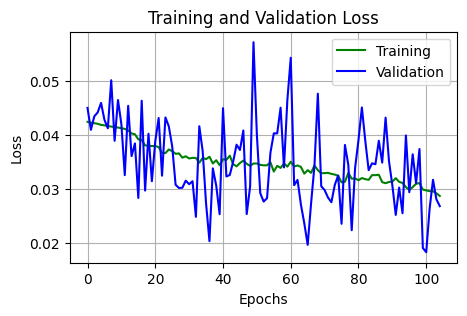

Final Training Loss:   0.031769
Final Validation Loss: 0.013825


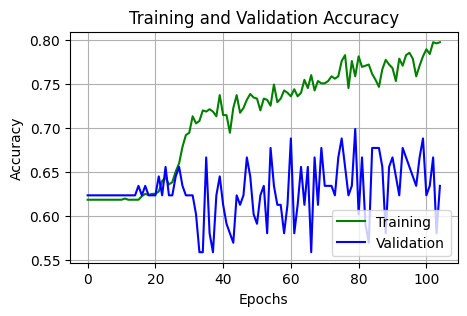

Final Training Accuracy:   0.756
Final Validation Accuracy: 0.655914

Test Accuracy: 0.6354



In [16]:
num_correct_test = 0
evalModel = model
evalModel.load_state_dict(torch.load(WEIGHTS_PATH))
evalModel.eval()

test_loss = 0
test_correct = 0

for idx, batch in enumerate(iter(test_iter)):
  predictions = model(batch.sentence.to(device))
  labels = F.one_hot(batch.label, num_classes=2).float().to(device)
  test_loss = criterion(predictions, labels)

  correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

  test_correct += correct.sum()
  test_loss += loss.item()

  val_losses[epoch]   = test_loss/N_val
  val_accuracy[epoch] = test_correct/N_val

test_accuracy = test_correct / N_test

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy,last_epoch)